In [1]:
from utils import dump_jsonl, load_jsonl, CLOSENESS_LABELS, AUTHORITY_LABELS
import pandas as pd
import numpy as np

In [2]:
CLOSENESS_LABELS = [
    "1. Very Close", 
    "2. Close", 
    "3. Know each other", 
    "4. Don't know each other", 
    # "5. Don't like each other"
]

ALL_CLOSENESS_LABELS = [
    "1. Very Close", 
    "2. Close", 
    "3. Know each other", 
    "4. Don't know each other", 
    "5. Don't like each other"
]

In [3]:
from collections import defaultdict

# ordinal_weights
def get_weights(categories):
    weights = defaultdict(dict)
    if len(categories)==3:
        mat = [[1.00, 0.67, 0.00], 
               [0.67, 1.00, 0.67], 
               [0.00, 0.67, 1.00]]
    elif len(categories)==4:
        mat = [[1.00, 0.83, 0.50, 0.00], 
               [0.83, 1.00, 0.83, 0.50], 
               [0.50, 0.83, 1.00, 0.83], 
               [0.00, 0.50, 0.83, 1.00]]
    elif len(categories)==5:
        mat = [[1, 0.9, 0.7, 0.4, 0.0], 
               [0.9, 1, 0.9, 0.7, 0.4], 
               [0.7, 0.9, 1, 0.9, 0.7], 
               [0.4, 0.7, 0.9, 1, 0.9],
               [0.0, 0.4, 0.7, 0.9, 1]]
    else:
        # Lazy to implement in case of len(categories) > 5
        raise Exception("No Implementation")
        
    for i, l in enumerate(categories): 
        for j, k in enumerate(categories): 
            weights[l][k] = mat[i][j]
    return weights

    
def cal_agreement(df1, df2, column, categories, cat_column):
    merged = pd.merge(df1, df2, on=column)
#     assert(len(df1)==len(merged))
    # merged = merged.dropna()    
    cnt_matrix = defaultdict(dict)
    acc_matrix = defaultdict(dict)
    
    for l in categories: 
        for k in categories: 
            d = merged
            d = d[d[f"{cat_column}_x"]==k]
            d = d[d[f"{cat_column}_y"]==l]
            cnt_matrix[l][k] = len(d)
    
    for l in categories: 
        d = merged
        d = d[d[f"{cat_column}_x"]==l]
        acc_matrix["x"][l] = len(d)
        
        d = merged
        d = d[d[f"{cat_column}_y"]==l]
        acc_matrix["y"][l] = len(d)

    print("cnt_matrix", cnt_matrix)
    print("acc_matrix", acc_matrix)
    
    weights = get_weights(categories)
    
    N = len(merged)
    Pa = 0
    for l in categories: 
        for k in categories: 
            Pa += weights[l][k]*cnt_matrix[l][k]/N
    
    Pe = 0
    for l in categories: 
        for k in categories: 
            Pe += weights[l][k]*(acc_matrix["x"][l]/N)*(acc_matrix["y"][k]/N)
    
    if Pe==1:
        raise Exception("Divide by zero")
    
    kappa = (Pa-Pe)/(1-Pe)
    return kappa


## Task1

In [4]:
data = load_jsonl("./Task1/annotated_conersations.jsonl")

Loaded 1234 records from ./Task1/annotated_conersations.jsonl


In [5]:
data = pd.DataFrame(data)

In [6]:
# data = data[~pd.isna(data["relationship"])]

In [7]:
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.patches import Patch

sns.set()

def bar_plot(labels, values, figname=None, as_percentage=True):
    plt.rcParams.update({'font.size': 15})
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    if as_percentage:
        norm = sum(values)
        values = [v*100/norm for v in values]
        bar_labels = [f"{v:.2f}%" for v in values]
        plt.ylim([0, 100])
    else:
        bar_labels = [f"{v:.2f}" for v in values]
    
    x = np.arange(len(values))  # the label locations
    width = 0.75  # the width of the bars
    multiplier = 0

    rects = ax.bar(x, values, width, label=labels, color=sns.color_palette())
    
    barlabels = ax.bar_label(rects, padding=3)
    for bl, l in zip(barlabels, bar_labels):
        bl.set_font_properties({'size': 20})
        bl.set_text(l)
    
    cmap = dict(zip(label2newlabel(labels), sns.color_palette()))
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]

    # add the legend
    plt.legend(handles=patches, loc='upper left', prop={'size': 15})
    ax.set_xticks(x, labels)
    ax.set_xticklabels(labels, rotation=0, ha='center')
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    if figname is not None:
        plt.savefig(f'{figname}.png', bbox_inches='tight', dpi=150)
        plt.savefig(f'{figname}.pdf', bbox_inches='tight', dpi=150)
    plt.show()
    


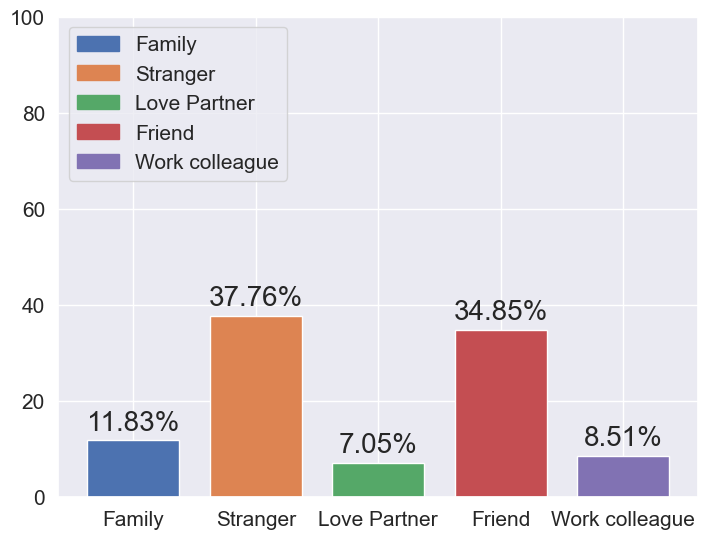

In [8]:
rel_maps = {
    'คนในครอบครัว (Family)': 'Family',
    'คนไม่รู้จัก (Stranger)': 'Stranger',
    'คู่รัก (Love Partner)': 'Love Partner',
    'เพื่อน (Friend)': 'Friend',
    'เพื่อนร่วมงาน (Work colleague)': 'Work colleague',
}

def label2newlabel(label):
    return label

cnt = data.groupby("relationship").count()
labels = [rel_maps[rel] for rel in cnt.index]
values = cnt["topic"].values*100/len(data)
bar_plot(labels, values, figname="Figures/task1-relationship")

In [9]:
labelmap = {
    '1. Very Close': "1. Intimate", 
    '2. Close': "2. Close", 
    '3. Know each other': "3. Acquainted", 
    "4. Don't know each other": "4. Unfamiliar",
    # "5. Don't like each other": "5. Dislike",
    
    
    '0. Very respect': "0. Highly Respectful", 
    '1. Respect': "1. Respectful", 
    '2. Normal': "2. Normal", 
    '3. Not respect': "3. Disrespectful"
}

def label2newlabel(label):
    if type(label) is list or type(label) is np.ndarray:
        return [labelmap[l] if l in labelmap else l for l in label ]
    
    if label in labelmap:
        return labelmap[label]
    return label

In [10]:
label2newlabel(data.authority.unique())

['1. Respectful',
 '0. Highly Respectful',
 '2. Normal',
 None,
 '3. Disrespectful']

['1. Very Close', '2. Close', '3. Know each other', "4. Don't know each other"]

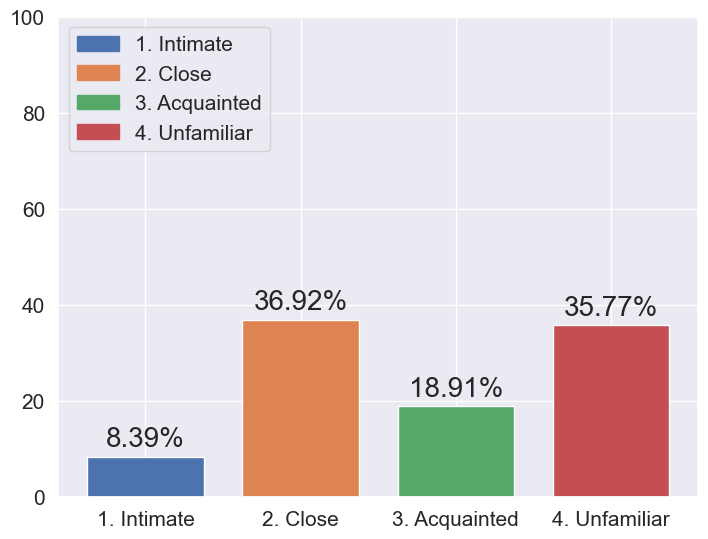

In [12]:
cnt = data.groupby("closeness").count()

labels = CLOSENESS_LABELS
values = [cnt["topic"][c] for c in labels]
bar_plot(label2newlabel(labels), values, figname="Figures/task1-close")

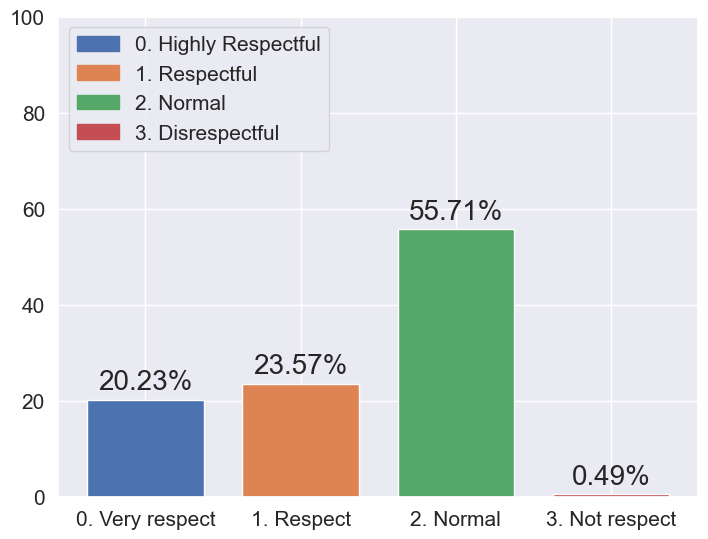

In [13]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["topic"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task1-auth")

#### Closeness/Respect Correlation

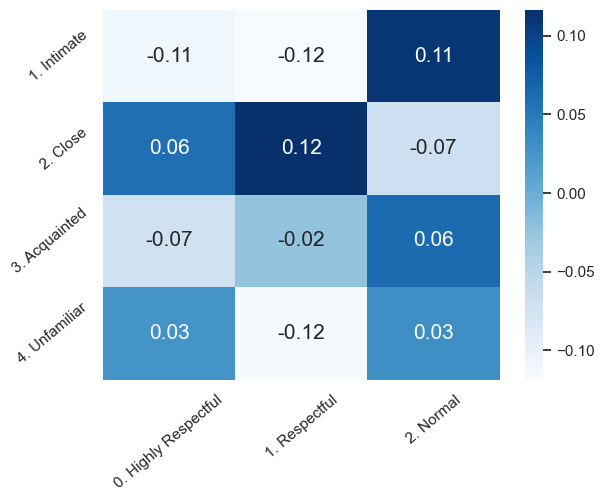

In [14]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_heatmap(data, xlabels, ylabels):

    mat = []
    
    for clos in ylabels:
        row = []
        for auth in xlabels:
            d = data
            d = d[d["closeness"]==clos]
            d = d[d["authority"]==auth]
            p_clos_auth = len(d)/len(data)
            if p_clos_auth==0:
                p_clos_auth = 0.1/len(data)
                
#             row.append(p_clos_auth)
            
            p_clos = len(data[data["closeness"]==clos])/len(data)
            p_auth = len(data[data["authority"]==auth])/len(data)
            pmi = np.log2(p_clos_auth/(p_clos*p_auth))
            row.append(pmi)
        
        mat.append(row)

    ax = sns.heatmap(mat, annot=True, fmt=".2f", cmap="Blues")
    ax.set(xlabel="", ylabel="")
    ax.yaxis.set_ticklabels(label2newlabel(ylabels), rotation=40)
    ax.xaxis.set_ticklabels(label2newlabel(xlabels), rotation=40)
    

AUTHORITY_LABELS1 = ['0. Very respect', '1. Respect', '2. Normal']
plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS)

In [15]:
# !pip install scikit-learn

In [16]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

In [17]:
d = data.dropna()
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.013463317145404555

Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement.

## Task 2

In [18]:
data = load_jsonl("./Task2/annotated_conersations.jsonl")

Loaded 2486 records from ./Task2/annotated_conersations.jsonl


In [19]:
data = pd.DataFrame(data)

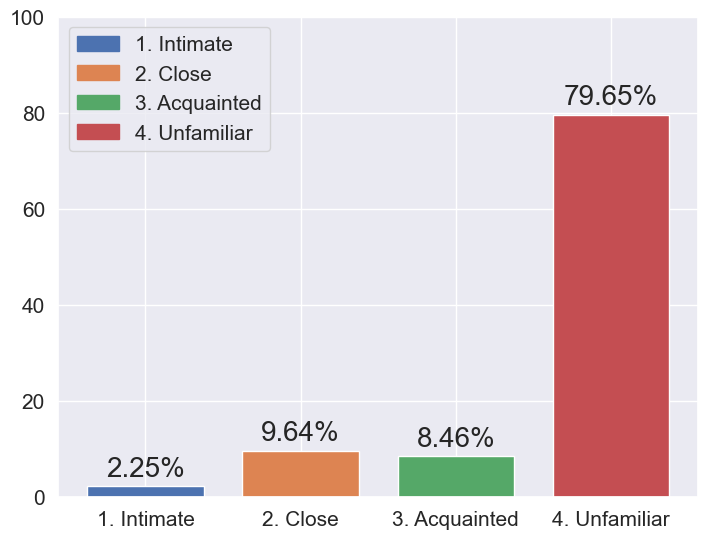

In [21]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["text"][c] for c in labels]
bar_plot(label2newlabel(labels), values, figname="Figures/task2-clos")

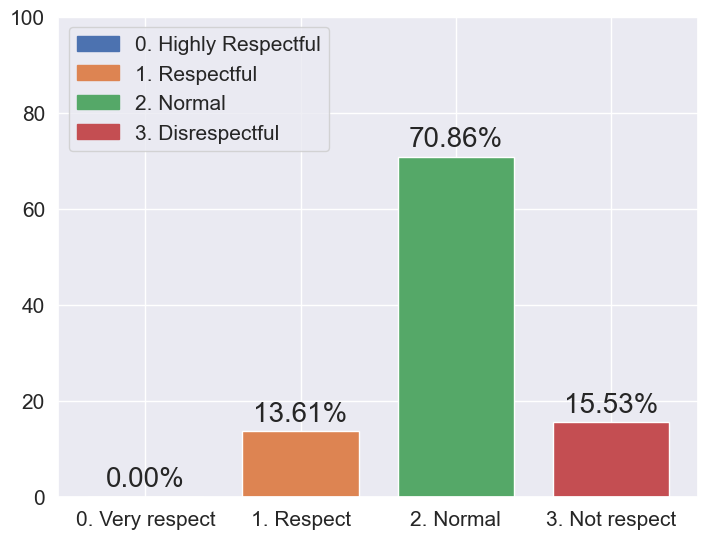

In [22]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["text"][c] if c in cnt["text"] else 0 for c in labels ]
bar_plot(labels, values, figname="Figures/task2-auth")

In [23]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
data = data[~pd.isna(data["closeness"])]
data = data[~pd.isna(data["authority"])]

d = data
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.2307335582319892

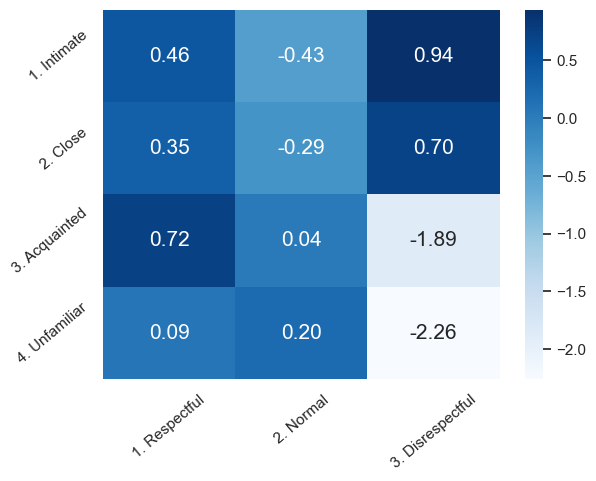

In [24]:
AUTHORITY_LABELS1 = ['1. Respect', '2. Normal', '3. Not respect']

plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS)


In [25]:
data["_id"] = data.index

In [27]:
def cal_agreement(df1, df2, column, categories, cat_column):
    merged = pd.merge(df1, df2, on=column)
#     assert(len(df1)==len(merged))
    merged = merged[[f"{cat_column}_x", f"{cat_column}_y"]]
    merged = merged.dropna()    
    cnt_matrix = defaultdict(dict)
    acc_matrix = defaultdict(dict)
    
    for l in categories: 
        for k in categories: 
            d = merged
            d = d[d[f"{cat_column}_x"]==k]
            d = d[d[f"{cat_column}_y"]==l]
            cnt_matrix[l][k] = len(d)
    
    for l in categories: 
        d = merged
        d = d[d[f"{cat_column}_x"]==l]
        acc_matrix["x"][l] = len(d)
        
        d = merged
        d = d[d[f"{cat_column}_y"]==l]
        acc_matrix["y"][l] = len(d)

    # print("cnt_matrix", cnt_matrix)
    # print("acc_matrix", acc_matrix)
    
    weights = get_weights(categories)
    
    N = len(merged)
    Pa = 0
    for l in categories: 
        for k in categories: 
            Pa += weights[l][k]*cnt_matrix[l][k]/N
    
    Pe = 0
    for l in categories: 
        for k in categories: 
            Pe += weights[l][k]*(acc_matrix["x"][l]/N)*(acc_matrix["y"][k]/N)
    
    if Pe==1:
        raise Exception("Divide by zero")
    
    kappa = (Pa-Pe)/(1-Pe)
    return kappa


avgiaa = []

for c1, c2 in [("closeness_1", "closeness_2"), ("closeness_1", "closeness_3"), ("closeness_3", "closeness_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["closeness"] = data1[c1]
    data2["closeness"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=ALL_CLOSENESS_LABELS, cat_column="closeness")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.5540869653457806
0.5834776463274761
0.45310741967607876


0.5302240104497785

In [28]:
avgiaa = []
for c1, c2 in [("authority_1", "authority_2"), ("authority_1", "authority_3"), ("authority_3", "authority_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["authority"] = data1[c1]
    data2["authority"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=AUTHORITY_LABELS, cat_column="authority")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.7734303485928611
0.5391800052226501
0.6624249765952915


0.6583451101369343

## Task 3

In [29]:
data = load_jsonl("./Task3/annotated_conersations.jsonl")
data = pd.DataFrame(data)

Loaded 1221 records from ./Task3/annotated_conersations.jsonl


In [32]:
# data.head()

In [33]:
# data

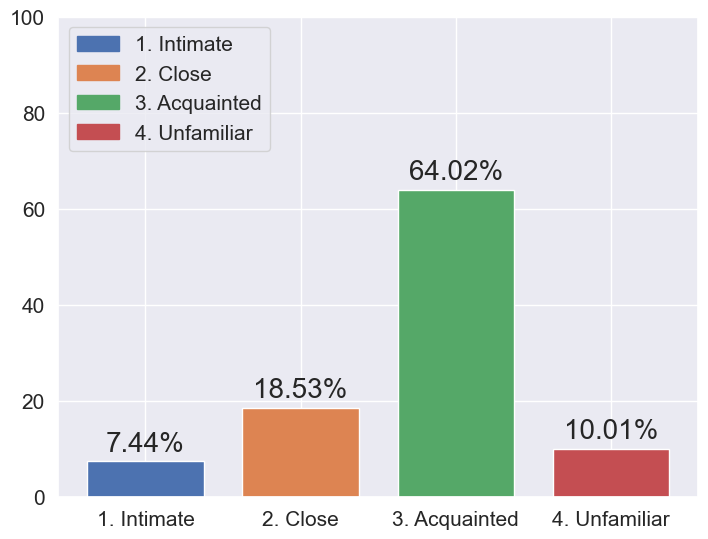

In [34]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["messages"][c] for c in labels]
bar_plot(label2newlabel(labels), values, figname="Figures/task3-clos")

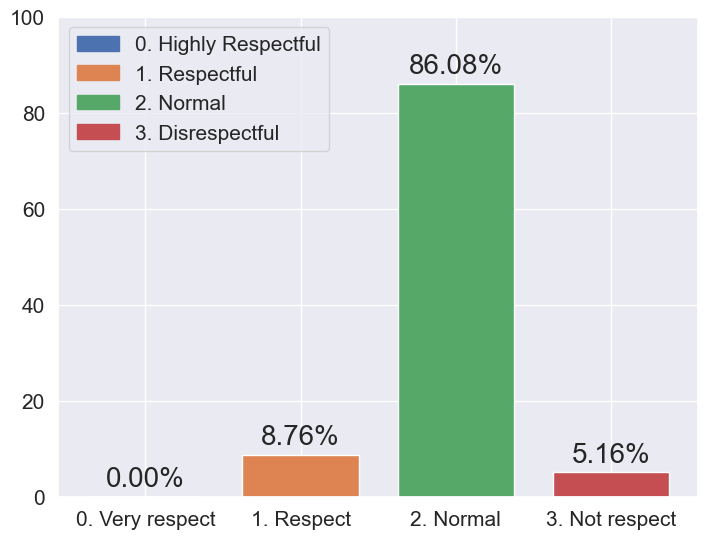

In [35]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["messages"][c] if c in cnt["messages"] else 0 for c in labels ]
bar_plot(labels, values, figname="Figures/task3-auth")

In [36]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
data = data[~pd.isna(data["closeness"])]
data = data[~pd.isna(data["authority"])]

d = data
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.13525127476500484

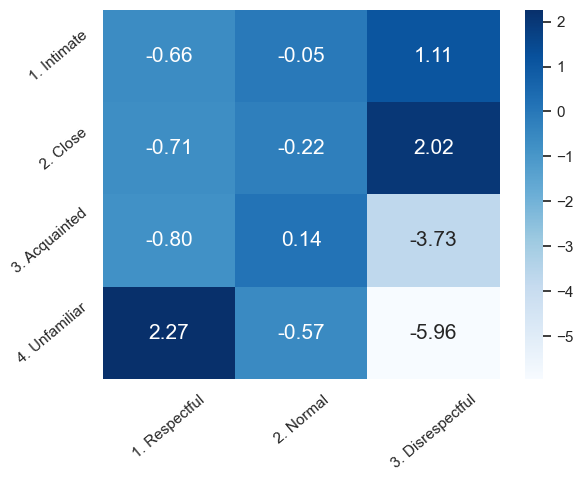

In [38]:
AUTHORITY_LABELS1 = ['1. Respect', '2. Normal', '3. Not respect']


plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS)


In [39]:
# AUTHORITY_LABELS1 = ['1. Respect', '2. Normal', '3. Not respect']
# CLOSENESS_LABELS1 = ['1. Close', '2. Know each other', "3. Don't know each other"]


# plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS1)


In [40]:
data["_id"] = data.index

In [41]:
avgiaa = []
for c1, c2 in [("closeness_1", "closeness_2"), ("closeness_1", "closeness_3"), ("closeness_3", "closeness_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["closeness"] = data1[c1]
    data2["closeness"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=ALL_CLOSENESS_LABELS, cat_column="closeness")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.5205475229248763
0.2810171662042267
0.4507861989131486


0.41745029601408384

In [42]:
avgiaa = []
for c1, c2 in [("authority_1", "authority_2"), ("authority_1", "authority_3"), ("authority_3", "authority_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["authority"] = data1[c1]
    data2["authority"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=AUTHORITY_LABELS, cat_column="authority")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.3686533472242451
0.12679415564199856
0.4450650616937025


0.3135041881866487

In [43]:
len(data)

1221

#### Agreement between self-reported and percieved

In [45]:
data1 = load_jsonl("./Task1/annotated_conersations.jsonl")
data1 = pd.DataFrame(data1)

Loaded 1234 records from ./Task1/annotated_conersations.jsonl


In [46]:
data3 = load_jsonl("./Task3/annotated_conersations.jsonl")
data3 = pd.DataFrame(data3)

Loaded 1221 records from ./Task3/annotated_conersations.jsonl


In [47]:
from collections import defaultdict

# ordinal_weights
def get_acc_weights(categories):
    weights = defaultdict(dict)
    if len(categories)==3:
        # mat = [[1.00, 0.67, 0.00], 
        #        [0.67, 1.00, 0.67], 
        #        [0.00, 0.67, 1.00]]
        mat = [[1.00, 0.5, 0.00], 
               [0.5, 1.00, 0.5], 
               [0.00, 0.5, 1.00]]
    elif len(categories)==4:
        # mat = [[1.00, 0.83, 0.50, 0.00], 
        #        [0.83, 1.00, 0.83, 0.50], 
        #        [0.50, 0.83, 1.00, 0.83], 
        #        [0.00, 0.50, 0.83, 1.00]]
        mat = [[1.00, 0.5, 0.0, 0.00], 
               [0.5, 1.00, 0.5, 0.0], 
               [0.0, 0.5, 1.00, 0.5], 
               [0.00, 0.0, 0.5, 1.00]]
    else:
        # Lazy to implement in case of len(categories) > 5
        raise Exception("No Implementation")
        
    for i, l in enumerate(categories): 
        for j, k in enumerate(categories): 
            weights[l][k] = mat[i][j]
    
    return weights

from sklearn.metrics import f1_score, accuracy_score

def cal_accuracy(df1, df2, column, categories, cat_column):
    d = pd.merge(df1, df2, on=column)[[f"{cat_column}_x", f"{cat_column}_y"]].dropna()
    
    d1 = d[f"{cat_column}_x"]
    d2 = d[f"{cat_column}_y"]

    return {
        "f1": f1_score(d1, d2, labels=categories, average="weighted"),
        "accuracy": accuracy_score(d1, d2),
    }

In [61]:
iaa = cal_agreement(data1, data3, column="room_id", categories=ALL_CLOSENESS_LABELS, cat_column="closeness")
iaa

0.3645818222395826

In [62]:
data1.authority.unique(), data3.authority.unique()

(array(['1. Respect', '0. Very respect', '2. Normal', None,
        '3. Not respect'], dtype=object),
 array(['2. Normal', '3. Not respect', '1. Respect'], dtype=object))

In [63]:
data1["m_authority"] = data1["authority"].map({
    '0. Very respect': None,
    '1. Respect': '1. Respect', 
    '2. Normal': '2. Normal', 
    '3. Not respect': '3. Not respect', 
    
})

data3["m_authority"] = data3["authority"]

In [64]:
data1["authority"].unique(), data3["authority"].unique()

(array(['1. Respect', '0. Very respect', '2. Normal', None,
        '3. Not respect'], dtype=object),
 array(['2. Normal', '3. Not respect', '1. Respect'], dtype=object))

In [65]:
iaa = cal_agreement(data1, data3, column="room_id", categories=AUTHORITY_LABELS[1:], cat_column="m_authority")
iaa

0.07712904199332042

In [68]:
cal_accuracy(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="m_authority")

{'f1': 0.5880499186817748, 'accuracy': 0.6349534643226473}

In [73]:
cal_accuracy(data1, data3, column="room_id", categories=ALL_CLOSENESS_LABELS, cat_column="closeness")

{'f1': 0.35015205763030544, 'accuracy': 0.343980343980344}

In [70]:
cal_accuracy(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="authority")

{'f1': 0.4122425887840673, 'accuracy': 0.5061830173124485}